# Implement a physically correct distribution

In order to understand lubrication better, we simulate thin layers of lubricant on a metallic surface, solvated in water.
Different structures of lubricant films are created by varying parameters like their concentration and the charge of the surface.
The lubricant is somewhat solvable in water, thus parts of the film will diffuse into the bulk water.
Lubricant molecules are charged, and their distribution is roughly exponential.

So, let's first generate a simple exponential distribution:

In [1]:
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt

from generate_structure import generate_structure 
from generate_structure import plot_dist
from generate_structure import get_histogram
from generate_structure import exponential

np.random.seed(74)

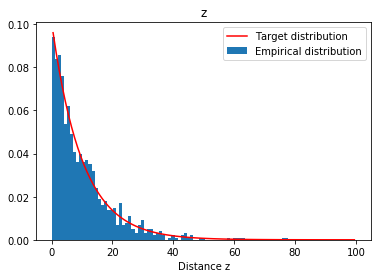

In [2]:
box = np.array([50, 50, 100])
struc = generate_structure(distribution=exponential, box=box, atom_count=1000)
histx, histy, histz = get_histogram(struc, box=box)
plot_dist(histz, 'z', reference_distribution=exponential)

This seems to work reasonably well, but does not describe a physical system - units and the slope of the exponential are rather abitrary.

Now, to incorporate a precise physical description of the distribution, we describe the concentration of our ion species, $c_{Na^+}$, by the solution to the Poisson-Bolzmann equation:

$
\begin{align}
\rho_{Na^+}(z) &= \rho_{Na^+}(\infty) e^{-e \Psi(z)/k_B T}\\
\Psi(z) &= \frac{2k_B T}{e} \log\Big(\frac{1 + \gamma e^{-\kappa z}}{1- \gamma e^{-\kappa z}}\Big) 
        \approx \frac{4k_B T}{e} \gamma e^{-\kappa z} \\
\gamma &= \tanh(\frac{e\Psi(0)}{4k_B T})\\
\kappa &= 1/\lambda_D\\
\lambda_D &= \Big(\frac{\epsilon \epsilon_0 k_B T}{\sum_{i} \rho_i(\infty) e^2 z_i^2} \Big)^\frac{1}{2} [m^{-1}]
\end{align}
$

With:
* $z$: Distance from the double layer
* $\Psi(0)$: Potential at the surface
* $\Psi(z)$: Potential in the solution
* $k_B$: Bolzmann Constant
* $T$: Temperature [Kelvin]
* $e$: Elemental Charge (or Euler's constant when exponentiated)
* $\gamma$: Term from Gouy-Chapmann theory
    * $\gamma \rightarrow 1$ for high potentials
    * $\Psi(z) \approx \Psi_0 e^{-\kappa z}$ for low potentials $\Psi(0) \approx 0$
* $\lambda_D$: Debye Length (34.0 nm for NaCl, 10^-4 M, 25°C)
* $\rho_{Na^+}$: Concentration of Natrium ions
* $\rho_{Na^+}(\infty)$: Bulk Natrium concentration (at infinity, where the solution is homogeneous)
* $\epsilon$: Permittivity of the solution
* $\epsilon_0$: Electric constant aka Vacuum permittivity
* $z_i$: Charge of species i 


Let's translate these equations into python code.

## Debye length
We start with the expression for the Debye length, which describes the thickness of the ionic double layer, or the distance at which the surface charge is mostly screened off.

Debye Length of 10^-4 M saltwater: 30.52 nm (Target: 30.4 nm)


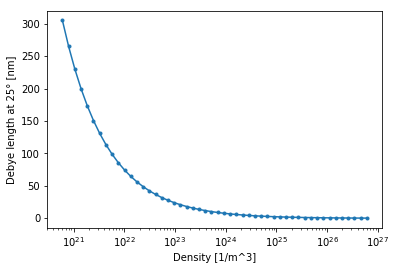

In [3]:
def debye(rho_bulk, charge, permittivity=79, temperature=298.15):
    """Calculate the Debye length.
    The Dybe length indicates at which distance a charge will be screened off.
    
    Arguments:
    rho_bulk: dictionary of the bulk number densites for each ionic species [1/m^3]
    charge: dictionary of the charge of each ionic species [1]
    permittivity: capacitance of the ionic solution [1]
    temperature: Temperature of the solution [K]
    
    Returns:
    float: the Debye length [m], should be around 10^-19
    
    Example: the Debye length of 10^-4 M salt water is 30.4 nm.
    >>> density = sc.Avogadro * 1000 * 10**-4
    >>> rho = {'Na': density, 'Cl': density} 
    >>> charge = {'Na': 1, 'Cl': -1}
    >>> deb = debye(rho_bulk=rho, charge=charge) * 10**9
    >>> deb - 30.4 < 0.5
    True    
    """
    # The numerator of the expression in the square root
    # e_r * e_0 * k_B * T
    numerator = permittivity * sc.epsilon_0 * sc.Boltzmann * temperature     

    # The divisor of the expression in the square root
    # \sum_i rho_i e^2 z_i^2
    divisor = 0
    for key in rho_bulk.keys():
        divisor += rho_bulk[key] * sc.elementary_charge ** 2 * charge[key] ** 2
        
    # The complete square root
    return np.sqrt(numerator / divisor)

# Factor of 1000 is due to 1/m^3, would be 1 for 1/l
default_density = sc.Avogadro * 1000 * 10**-4
rho = {'Na': default_density, 'Cl': default_density} 
charge = {'Na': 1, 'Cl': -1}
deb = debye(rho_bulk=rho, charge=charge) * 10**9
print('Debye Length of 10^-4 M saltwater: {} nm (Target: 30.4 nm)'.format(round(deb, 2)))

density = np.logspace(-6, 0, 50) * sc.Avogadro * 1000

debyes = [debye(rho_bulk={'Na': d, 'Cl': d}, charge=charge) * 10**9 for d in density]
plt.xlabel('Density [1/m^3]')
plt.ylabel('Debye length at 25° [nm]')
plt.semilogx(density, debyes, marker='.')
plt.show()

The debye length depends on the concentration of ions in solution, at low concentrations it becomes large. We can reproduce literature debye lengths with our function, so everything looks good.

## Gamma Function

Next we calculate the gamma function $\gamma = \tanh(\frac{e\Psi(0)}{4k_B T})$

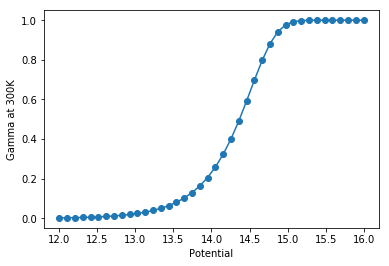

In [4]:
def gamma(surface_potential, temperature):
    """Calculate term from Gouy-Chapmann theory."""
    product = sc.elementary_charge * surface_potential / (4 * sc.Stefan_Boltzmann * temperature)
    return np.tanh(product)

x = np.linspace(12, 16, 40)
gammas = [gamma(10 ** i, 300) for i in x]
plt.xlabel('Potential')
plt.ylabel('Gamma at 300K')
plt.plot(x, gammas, marker='o')
plt.show()

Which looks as expected, but we have no values to compare it against.

## Potential

We plug these two functions, into the expression for the potential

$\Psi(z) = \frac{2k_B T}{e} \log\Big(\frac{1 + \gamma e^{-\kappa z}}{1- \gamma e^{-\kappa z}}\Big) 
        \approx \frac{4k_B T}{e} \gamma e^{-\kappa z}$

In [5]:
def potential(location, rho_bulk, charge, surface_potential, temperature=300, permittivity=80):
    """The potential near a charged surface in an ionic solution.
    Arguments:
    location: z-distance from the surface [m]
    temperature: Temperature of the soultion [Kelvin] 
    gamma: term from Gouy-Chapmann theory
    kappa: the inverse of the debye length
    charge: dictionary of the charge of each ionic species
    permittivity: capacitance of the ionic solution []
    temperature: Temperature of the solution [Kelvin]
    
    Returns:
    psi: Electrostatic potential [V]
    """
    prefactor = 2 * sc.Stefan_Boltzmann * temperature / sc.elementary_charge
    
    gamma_value = gamma(surface_potential=surface_potential, temperature=temperature)
    debye_value = debye(rho_bulk=rho_bulk, charge=charge, permittivity=permittivity, temperature=temperature)
    kappa = 1/debye_value
    
    numerator = 1 + gamma_value * np.exp(-kappa * location)
    divisor = 1 - gamma_value * np.exp(-kappa * location)
    
    psi = prefactor * np.log(numerator / divisor)

    return psi

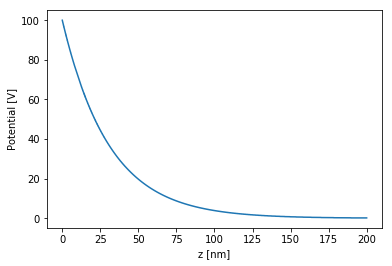

In [6]:
z = np.linspace(0, 2*10**-7, 10000)
density = sc.Avogadro * 1000 * 10**-4
rho = {'Na': density, 'Cl':density} 
charge = {'Na': 1, 'Cl': -1}
pot_0 = 100
psi = [potential(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0) for loc in z]
plt.xlabel('z [nm]')
plt.ylabel('Potential [V]')
plt.plot(z*10**9, psi, marker='')
plt.show()

As expected, this gives us an exponentially decaying potential.

Unfortunately, the differences in our potential calculation already strain python's numerical precision:

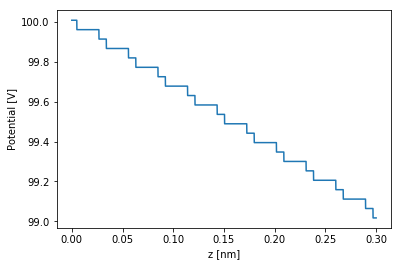

In [7]:
z = np.linspace(0, 3*10**-10, 10000)
psi = [potential(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0) for loc in z]
plt.xlabel('z [nm]')
plt.ylabel('Potential [V]')
plt.plot(z*10**9, psi, marker='')
plt.show()

These steps in the potential will lead to major errors in the density, so we want to remove them.

To get a smooth potential, we use the decimal package with increased float precision.

In [8]:
from decimal import *
getcontext().prec = 30

def precise_potential(location, rho_bulk, charge, surface_potential, temperature=300, permittivity=80):
    """The potential near a charged surface in an ionic solution.
    
    The decimal package is used for increased precision.
    
    Arguments:
    location: z-distance from the surface [m]
    temperature: Temperature of the soultion [Kelvin] 
    gamma: term from Gouy-Chapmann theory
    kappa: the inverse of the debye length
    charge: dictionary of the charge of each ionic species
    permittivity: capacitance of the ionic solution []
    temperature: Temperature of the solution [Kelvin]
    
    Returns:
    psi: Electrostatic potential [V]
    """
    prefactor = Decimal(2 * sc.Stefan_Boltzmann * temperature / sc.elementary_charge)
    
    debye_value =  debye(rho_bulk=rho_bulk, charge=charge, permittivity=permittivity, temperature=temperature)
    kappa = 1/debye_value

    gamma_value =  Decimal(gamma(surface_potential=surface_potential, temperature=temperature))    
    
    exponential = Decimal(np.exp(-kappa * location))
    numerator = Decimal(1) + gamma_value * exponential
    divisor =   Decimal(1) - gamma_value * exponential
    
    psi = prefactor * (numerator / divisor).ln()
    psi = float(psi)

    return psi

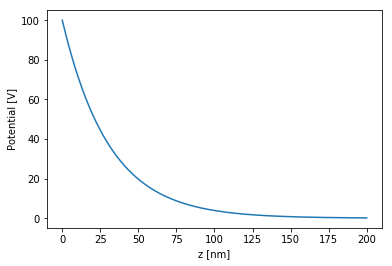

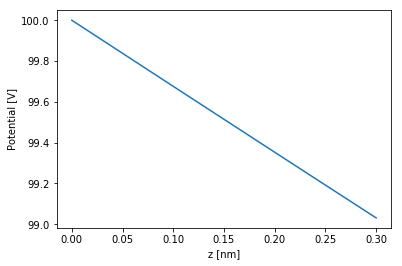

In [9]:
z = np.linspace(0, 2*10**-7, 10000)
density = sc.Avogadro * 1000 * 10**-4
rho = {'Na': density, 'Cl':density} 
charge = {'Na': 1, 'Cl': -1}
pot_0 = 100
psi = [precise_potential(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0) for loc in z]
plt.xlabel('z [nm]')
plt.ylabel('Potential [V]')
plt.plot(z*10**9, psi, marker='')
plt.show()

z = np.linspace(0, 3*10**-10, 10000)
psi = [precise_potential(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0) for loc in z]
plt.xlabel('z [nm]')
plt.ylabel('Potential [V]')
plt.plot(z*10**9, psi, marker='')
plt.show()

We can see that the steps in the potential are gone, everything is smooth now.

## Charge density

Now we obtain the charge density $\rho$ from the potential $\Psi$ via

$\rho_{Na^+}(z) = \rho_{Na^+}(\infty) e^{-e \Psi(z)/k_B T}$

In [10]:
def charge_density(location, rho_bulk, charge, surface_potential, temperature=300, permittivity=80, species='Na'):
    """The potential near a charged surface in an ionic solution.
    Arguments:
    location: z-distance from the surface [m]
    temperature: Temperature of the soultion [Kelvin] 
    gamma: term from Gouy-Chapmann theory
    kappa: the inverse of the debye length
    charge: dictionary of the charge of each ionic species
    permittivity: capacitance of the ionic solution []
    temperature: Temperature of the solution [Kelvin]
    
    Returns:
    rho: number density of salt ions
    """
    potential_value = precise_potential(location, rho_bulk, charge, surface_potential, temperature, permittivity)
    
    # Save the species' densities
    rho = rho_bulk[species] * np.exp(-1 * charge[species] * sc.elementary_charge * potential_value / (sc.Boltzmann * temperature))
        
    return rho

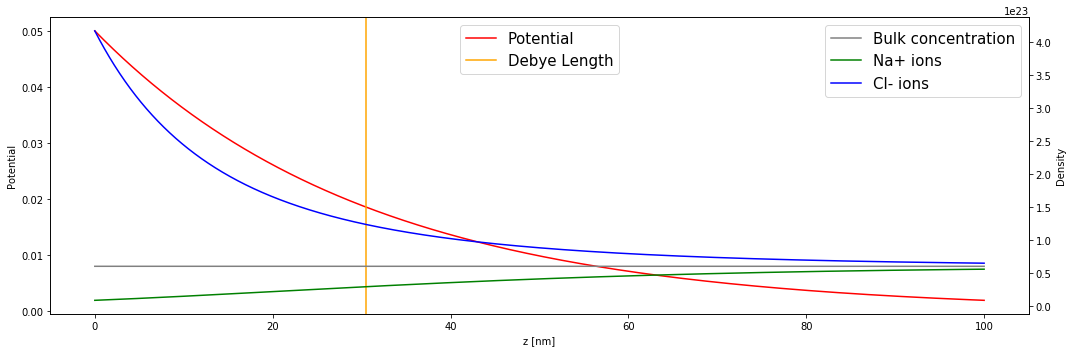

In [11]:
z = np.linspace(0, 100*10**-9, 2000)
density = sc.Avogadro * 1000 * 10**-4
rho = {'Na': density, 'Cl':density} 
charge = {'Na': 1, 'Cl': -1}
pot_0 = 0.05  # Breaks if > 1

psi = [precise_potential(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0) for loc in z]

rho_na = np.array([charge_density(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0, species='Na') for loc in z])
rho_cl = np.array([charge_density(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0, species='Cl') for loc in z])

deb = debye(rho_bulk=rho, charge=charge) * 10**9

fig, ax1 = plt.subplots(figsize=[15,5])
ax1.set_xlabel('z [nm]')
ax1.plot(z*10**9, psi, marker='', color='red', label='Potential')
ax1.set_ylabel('Potential')
ax1.axvline(x=deb, label='Debye Length', color='orange')

ax2 = ax1.twinx()
ax2.plot(z*10**9, [density]*len(z), label='Bulk concentration', color='grey')
ax2.plot(z*10**9, rho_na, marker='', color='green', label='Na+ ions')
ax2.plot(z*10**9, rho_cl, marker='', color='blue', label='Cl- ions')
ax2.set_ylabel('Density')

#fig.legend(loc='center')
ax2.legend(loc='best', fontsize=15)
ax1.legend(loc='upper center', fontsize=15)
fig.tight_layout()
plt.show()

The charge density behaves as expected, it interpolates between low (high) concentration and the bulk concentration within the first few debye lengths.

## Sampling
Now let's see if we can just plug our new distribution in our existing framework.

First, we need to convert the physical distribution to the format we were using so far:

In [12]:
def wrap_distribution(x, species):
    """Wrapper for na+ ions."""
    density = sc.Avogadro * 1000 * 10**-4
    rho = {'Na': density, 'Cl':density} 
    charge = {'Na': 1, 'Cl': -1}
    pot_0 = 0.05  # Breaks if > 1
    
    def call_distri(loc):
        distri = charge_density(location=loc, rho_bulk=rho, 
                                charge=charge, surface_potential=pot_0, species=species)
        return float(distri)
    
    if not np.isscalar(x):
        y = []
        for i in range(0, len(x)):
            val = call_distri(x[i])
            
            # Normalize to be 1 at x=0
            val /= call_distri(0)
            # Scale distribution to have values in [0, 0.1] for ease of sampling
            val /= 10
            y += [val]
        return np.array(y)

    # If we have only a point estimate
    val = call_distri(x)
    # Normalize to be 1 at x=0
    val /= call_distri(0)
    # Scale distribution to have values in [0, 0.1] for ease of sampling
    val /= 10    
    return val
    
def cl_distribution(x):
    return wrap_distribution(x, species='Cl')

    
def na_distribution(x):
    return wrap_distribution(x, species='Na')

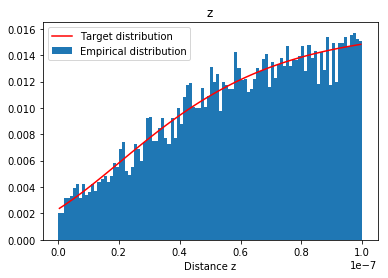

In [13]:
x = 50 * 10**-9
z = 100 * 10**-9
box = np.array([x, x, z])
struc = generate_structure(distribution=na_distribution, box=box, atom_count=10000)
histx, histy, histz = get_histogram(struc, box=box, n_bins=101)
plot_dist(histz, 'z', reference_distribution=na_distribution)

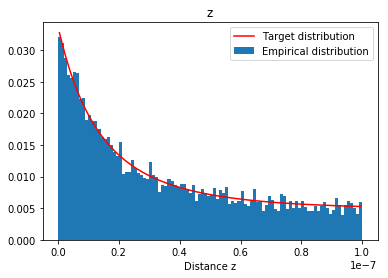

In [14]:
x = 50 * 10**-9
z = 100 * 10**-9
box = np.array([x, x, z])
struc = generate_structure(distribution=cl_distribution, box=box, atom_count=10000)
histx, histy, histz = get_histogram(struc, box=box, n_bins=101)
plot_dist(histz, 'z', reference_distribution=cl_distribution)

## Write to file
To visualize our structure, we export it to the .xyz file format, which is basically

```
ATOM_NUMBER
Optional comment
atom_type x y z
atom_type x y z
```

Avogadro expects x, y, z to be in units of $10^{-9}~m$, so we convert our salt "solution" to this unit.

In [15]:
from generate_structure import concat_names_structs
from generate_structure import export_named_struc

cl_struc = generate_structure(distribution=cl_distribution, box=box, atom_count=100)
na_struc = generate_structure(distribution=na_distribution, box=box, atom_count=100)

concat_list = concat_names_structs(struc_list=[cl_struc, na_struc], name_list=['Cl', 'Na'])
rescaled_list = []
for line in concat_list:
    name, x, y, z = line
    x = float(x) * 10**9
    y = float(y) * 10**9
    z = float(z) * 10**9    
    rescaled_list += [[name, x, y, z]]

rescaled_list = np.array(rescaled_list)
export_named_struc(rescaled_list)

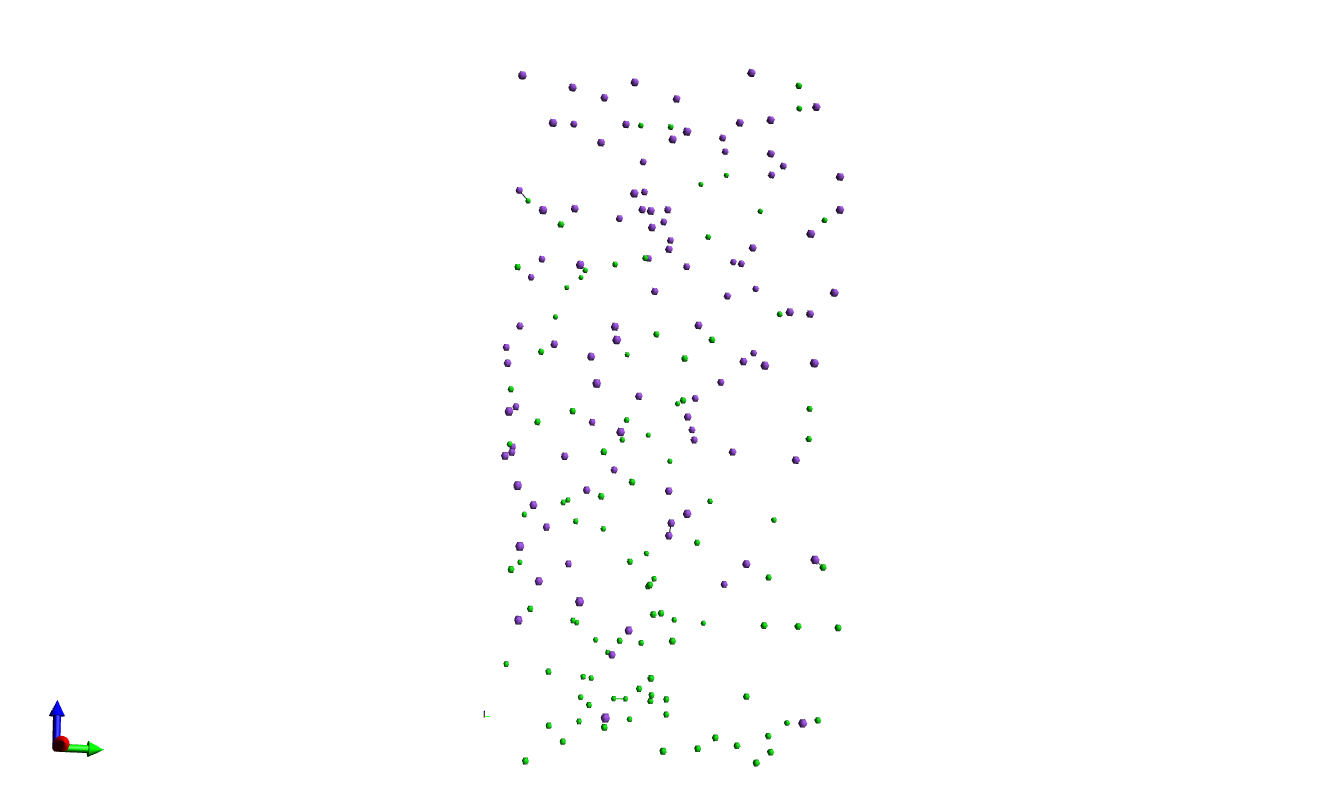

In [16]:
from IPython.display import Image
Image(filename='distributed_atom_structure.png') 